In [27]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# download the data
df = yf.download(tickers=['^GSPC'],start = '2018-01-01',end='2023-04-11', period='1')
y = df['Adj Close'].fillna(method='ffill')
y

# generate the input and output sequences





[*********************100%***********************]  1 of 1 completed


Date
2018-01-02    2695.810059
2018-01-03    2713.060059
2018-01-04    2723.989990
2018-01-05    2743.149902
2018-01-08    2747.709961
                 ...     
2023-04-03    4124.509766
2023-04-04    4100.600098
2023-04-05    4090.379883
2023-04-06    4105.020020
2023-04-10    4109.109863
Name: Adj Close, Length: 1326, dtype: float64

In [28]:
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)


In [118]:
n_lookback = 30  # length of input sequences (lookback period)
n_forecast = 5  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

In [119]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=100))
model.add(Dense(n_forecast))



In [156]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=64, verbose=0)


In [157]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)


1/1 [==============================] - 1s 1s/step


<ipython-input-158-e04fb19a30d6>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


<AxesSubplot:title={'center':'S&P500'}, xlabel='Date'>

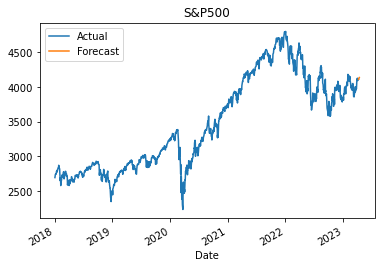

In [158]:
# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
results.plot(title='S&P500')

In [159]:
df_future

,Date,Actual,Forecast
0,2023-04-11,NaN,4109.737305
1,2023-04-12,NaN,4111.849609
2,2023-04-13,NaN,4127.316406
3,2023-04-14,NaN,4132.048340
4,2023-04-15,NaN,4134.281738


<AxesSubplot:xlabel='Date'>

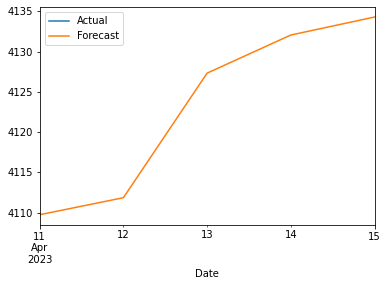

In [162]:
br = df_future.set_index('Date')
br.plot()